# Testing

A large-ish notebook that does some, mostly qualitative, testing of various _explorationlib_ functions.

### Shared imports

In [1]:
import shutil
import glob
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from explorationlib import agent
from explorationlib import local_gym as gym

from explorationlib.run import experiment
from explorationlib.util import select_exp
from explorationlib.util import load
from explorationlib.util import save

from explorationlib.plot import plot_position2d
from explorationlib.plot import plot_length_hist
from explorationlib.plot import plot_length
from explorationlib.plot import plot_targets2d

from explorationlib.score import search_efficiency
from explorationlib.score import average_reward

### Config notebook

In [2]:
%matplotlib inline
%load_ext nb_black
%config InlineBackend.figure_format='retina'
%config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2

plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = "16"

<IPython.core.display.Javascript object>

# Test - random search agents - 1
- First use the `gym.Field`, an open space. Verify the step length distributions, and qualitative behave/position data

In [3]:
env = gym.Field()
detection_radius = 1
min_l = 0.1
brown = agent.Diffusion2d(min_l=min_l, scale=1, detection_radius=detection_radius)
levy = agent.Levy2d(min_l=min_l, exponent=2, detection_radius=detection_radius)
uniform = agent.Uniform2d(min_l=min_l, max_l=10, detection_radius=detection_radius)

<IPython.core.display.Javascript object>

In [4]:
# How long to run? Longer is better, but slower.
num_steps = 50000

# Cleanup old versions
for path in glob.glob("data/test_*.pkl"):
    os.remove(path)
    
# !
experiment("data/test_uniform.pkl", uniform, env, num_steps=num_steps, num_experiments=1)
experiment("data/test_levy.pkl", levy, env, num_steps=num_steps, num_experiments=1)
experiment("data/test_brown.pkl", brown, env, num_steps=num_steps, num_experiments=1)

# Load the results
levy_exp = load("data/test_levy.pkl")
brown_exp = load("data/test_brown.pkl")
uni_exp = load("data/test_uniform.pkl")

test_brown: 100%|██████████| 1/1 [00:04<00:00,  4.72s/it]


<IPython.core.display.Javascript object>

### show available data from the experiment

In [5]:
levy_exp.keys()

dict_keys(['exp_step', 'num_experiment', 'exp_state', 'exp_action', 'exp_reward', 'exp_info', 'agent_num_turn', 'agent_angle', 'agent_l', 'agent_step', 'agent_num_step', 'agent_action', 'exp_name', 'num_experiments', 'exp_num_steps', 'env', 'agent'])

<IPython.core.display.Javascript object>

# Env and Agent log are the same size?

In [7]:
assert len(levy_exp["exp_reward"]) == len(levy_exp["agent_l"])

<IPython.core.display.Javascript object>

### plot position data

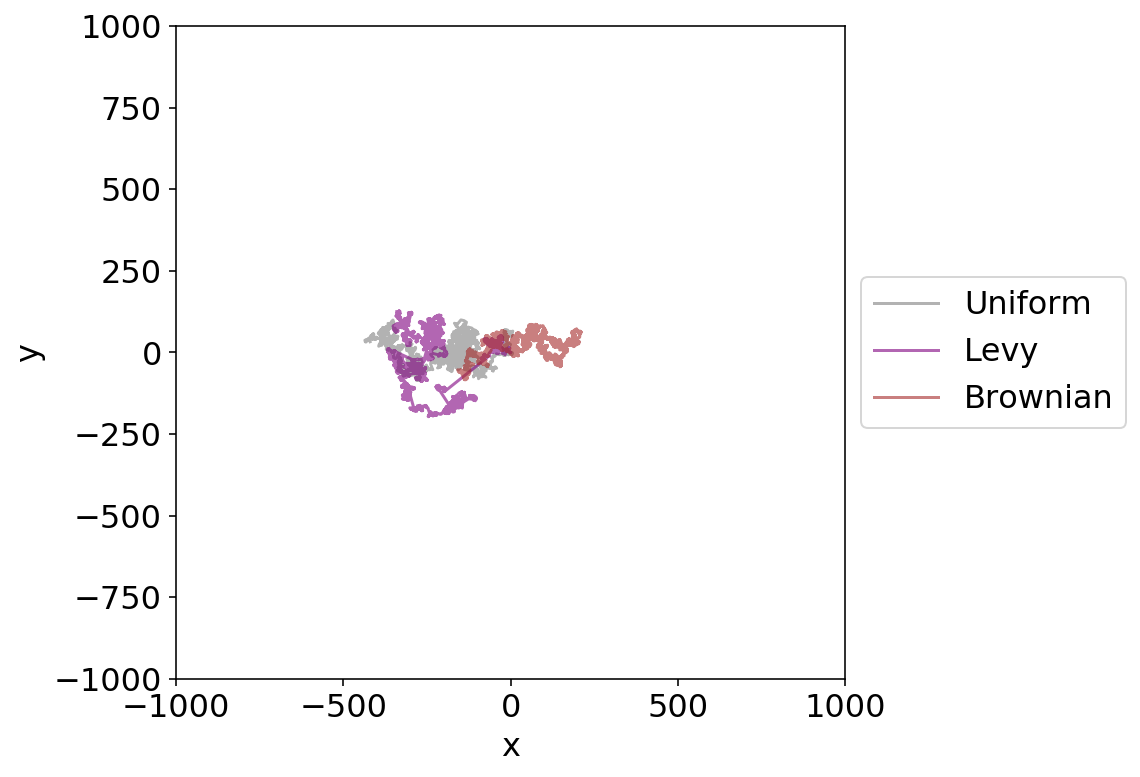

<IPython.core.display.Javascript object>

In [9]:
plot_boundary = (1000, 1000)

ax = plot_position2d(
    uni_exp,
    boundary=plot_boundary,
    label="Uniform",
    color="grey",
    alpha=0.6,
    figsize=(6, 6),
)
ax = plot_position2d(
    levy_exp,
    boundary=plot_boundary,
    label="Levy",
    color="purple",
    alpha=0.6,
    ax=ax,
)
ax = plot_position2d(
    brown_exp,
    boundary=plot_boundary,
    label="Brownian",
    color="brown",
    alpha=0.6,
    ax=ax,
)

### plot loglog length distributions

- _Uniform_ should be flat(ish) still
- _Diffusion_ should drop of quick for large l
- _Levy_ should be a downward going straight line

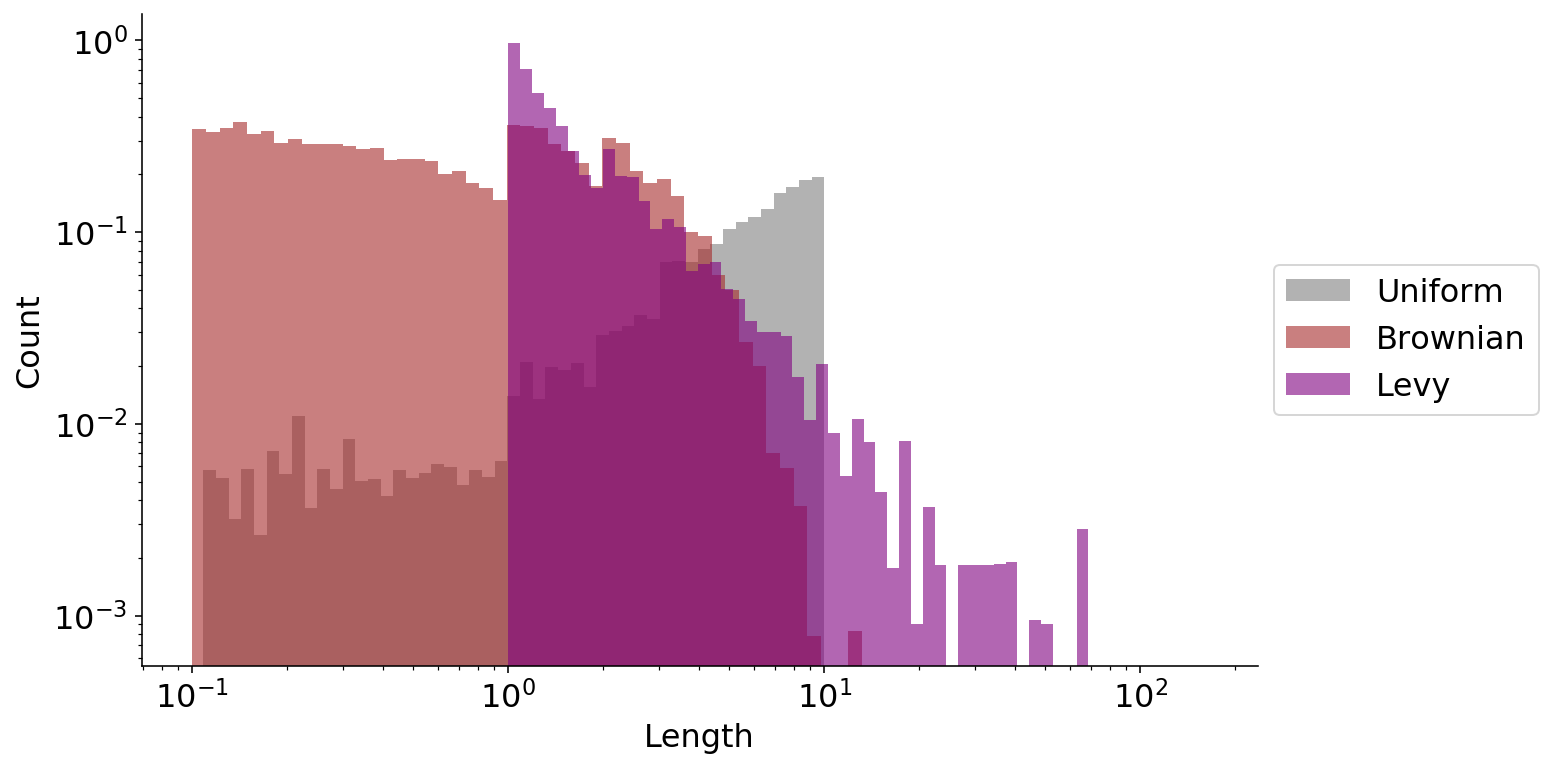

<IPython.core.display.Javascript object>

In [10]:
ax = plot_length_hist(
    uni_exp,
    loglog=True,
    bins=50,
    figsize=(10, 6),
    density=True,
    alpha=0.6,
    color="grey",
    label="Uniform",
)
ax = plot_length_hist(
    brown_exp,
    loglog=True,
    bins=50,
    density=True,
    alpha=0.6,
    color="brown",
    label="Brownian",
    ax=ax,
)
ax = plot_length_hist(
    levy_exp,
    loglog=True,
    bins=60,
    density=True,
    alpha=0.6,
    label="Levy",
    color="purple",
    ax=ax,
)

sns.despine()

# Test - random search agents - 2
- Next use the `gym.Field` with various (bounded) target distributions. Verify target gathering performance across agents.

In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

In [12]:
detection_radius = 2
target_boundary = (50, 50)

dense_env = gym.Field()
sparse_env = gym.Field()

dense_targets = gym.uniform_targets(500, target_boundary)
dense_values = gym.constant_values(dense_targets, 1)

sparse_targets = gym.uniform_targets(50, target_boundary)
sparse_values = gym.constant_values(sparse_targets, 1)

dense_env.add_targets(dense_targets, dense_values, detection_radius=detection_radius)
sparse_env.add_targets(sparse_targets, sparse_values, detection_radius=detection_radius)

<IPython.core.display.Javascript object>

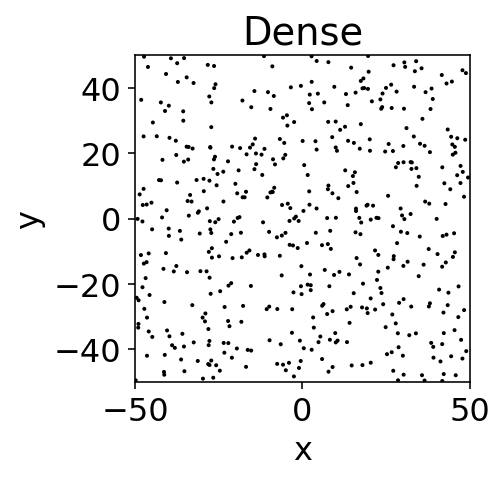

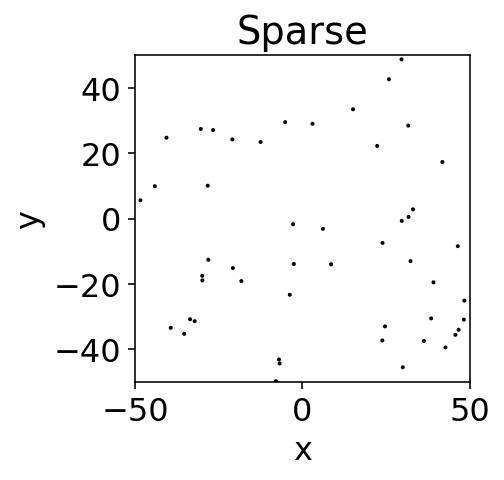

<IPython.core.display.Javascript object>

In [13]:
plot_targets2d(dense_env, boundary=target_boundary, title="Dense")
plot_targets2d(sparse_env, boundary=target_boundary, title="Sparse")

Values should be 1

In [14]:
dense_values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

<IPython.core.display.Javascript object>

Load agents

In [16]:
# Speed up the search w/ limits
min_l = 0.1
max_l = 5
# Init 
brown = agent.Diffusion2d(min_l=min_l, scale=0.5, detection_radius=detection_radius)
levy2 = agent.TruncatedLevy2d(min_l=min_l, max_l=max_l, exponent=2, detection_radius=detection_radius)
levy3 = agent.TruncatedLevy2d(min_l=min_l, max_l=max_l, exponent=3, detection_radius=detection_radius)

<IPython.core.display.Javascript object>

### Run 25 experiments
For both _Dense_ and _Sparse_ each with `num_steps`.

In [17]:
num_experiments = 100
num_steps = 1000

<IPython.core.display.Javascript object>

In [18]:
# Cleanup old versions
for path in glob.glob("data/dense_*.pkl"):
    os.remove(path)

experiment(
    f"data/dense_levy2.pkl",
    levy2,
    dense_env,
    num_steps=num_steps,
    num_experiments=num_experiments,
)
experiment(
    f"data/dense_levy3.pkl",
    levy3,
    dense_env,
    num_steps=num_steps,
    num_experiments=num_experiments,
)
experiment(
    f"data/dense_brown.pkl",
    brown,
    dense_env,
    num_steps=num_steps,
    num_experiments=num_experiments,
)

dense_brown: 100%|██████████| 100/100 [00:24<00:00,  4.11it/s]


<IPython.core.display.Javascript object>

In [24]:
# Cleanup old versions
for path in glob.glob("data/sparse_*.pkl"):
    os.remove(path)

experiment(
    f"data/sparse_levy2.pkl",
    levy2,
    sparse_env,
    num_steps=num_steps,
    num_experiments=num_experiments,
)
experiment(
    f"data/sparse_levy3.pkl",
    levy3,
    sparse_env,
    num_steps=num_steps,
    num_experiments=num_experiments,
)
experiment(
    f"data/sparse_brown.pkl",
    brown,
    sparse_env,
    num_steps=num_steps,
    num_experiments=num_experiments,
)

sparse_brown: 100%|██████████| 100/100 [00:19<00:00,  5.09it/s]


<IPython.core.display.Javascript object>

### Load the results

In [25]:
# Dense
levy2_dense = load("data/dense_levy2.pkl")
levy3_dense = load("data/dense_levy3.pkl")
brown_dense = load("data/dense_brown.pkl")
# Sparse
levy2_sparse = load("data/sparse_levy2.pkl")
levy3_sparse = load("data/sparse_levy3.pkl")
brown_sparse = load("data/sparse_brown.pkl")

<IPython.core.display.Javascript object>

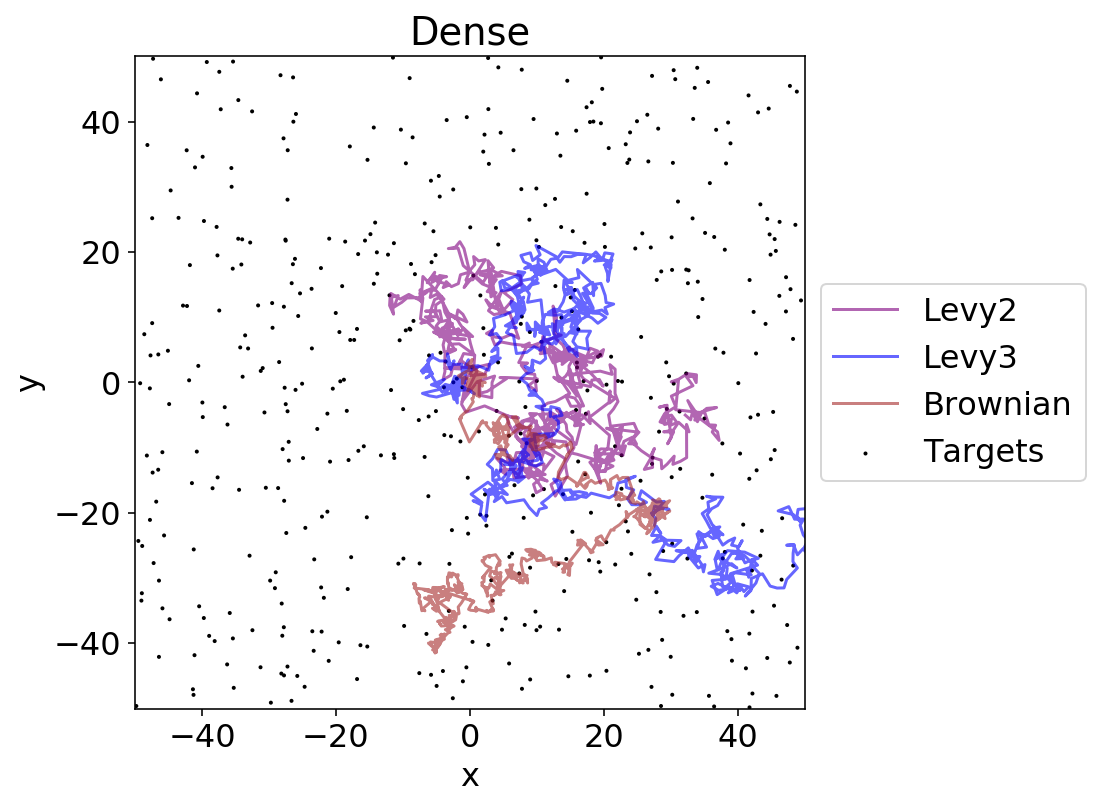

<IPython.core.display.Javascript object>

In [29]:
plot_boundary = (50, 50)

num_experiment = 3
ax = plot_position2d(
    select_exp(levy2_dense, num_experiment),
    boundary=plot_boundary,
    label="Levy2",
    color="purple",
    alpha=0.6,
    title="Dense",
    figsize=(6, 6),
)
ax = plot_position2d(
    select_exp(levy3_dense, num_experiment),
    boundary=plot_boundary,
    label="Levy3",
    color="blue",
    alpha=0.6,
    ax=ax,
)
ax = plot_position2d(
    select_exp(brown_dense, num_experiment),
    boundary=plot_boundary,
    label="Brownian",
    color="brown",
    alpha=0.6,
    ax=ax,
)
ax = plot_targets2d(
    dense_env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)

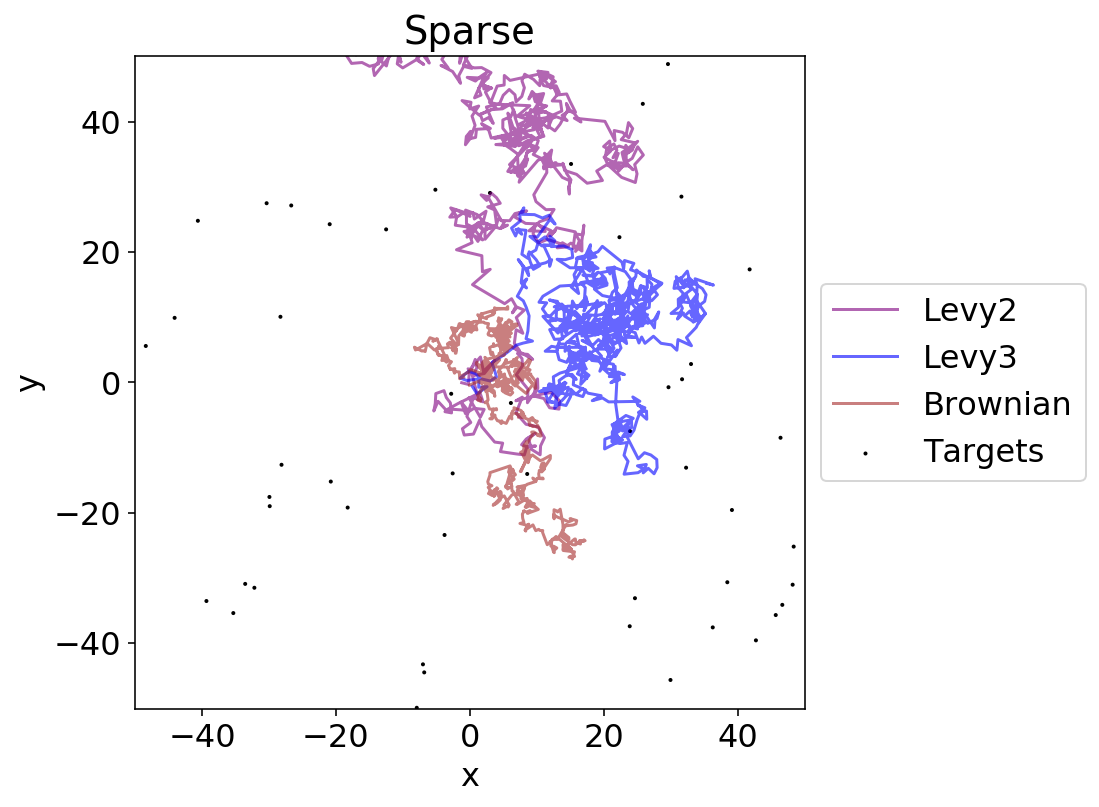

<IPython.core.display.Javascript object>

In [30]:
plot_boundary = (50, 50)

num_experiment = 0
ax = plot_position2d(
    select_exp(levy2_sparse, num_experiment),
    boundary=plot_boundary,
    label="Levy2",
    color="purple",
    alpha=0.6,
    title="Sparse",
    figsize=(6, 6),
)
ax = plot_position2d(
    select_exp(levy3_sparse, num_experiment),
    boundary=plot_boundary,
    label="Levy3",
    color="blue",
    alpha=0.6,
    ax=ax,
)
ax = plot_position2d(
    select_exp(brown_sparse, num_experiment),
    boundary=plot_boundary,
    label="Brownian",
    color="brown",
    alpha=0.6,
    ax=ax,
)
ax = plot_targets2d(
    sparse_env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)

### Plot agents, by targets

In [35]:
names = ["Levy-2", "Levy-3", "Brownian"]
fig = plt.figure(figsize=(6, 7))

# Dense
scores = []
for a in [levy2_dense, levy3_dense, brown_dense]:
    r = search_efficiency(a)
    scores.append(r)

if np.sum(scores) > 0:
    m = []
    sd = []
    for i, s in enumerate(scores):
        m.append(np.mean(s))
        sd.append(np.std(s))
    plt.subplot(211)
    plt.bar(names, m, yerr=sd, color="black", alpha=0.7)
    plt.ylabel("Rewards")
    plt.title("Dense")
else:
    print("Dense", scores)

# Sparse
scores = []
for a in [levy2_sparse, levy3_sparse, brown_sparse]:
    r = search_efficiency(a)
    scores.append(r)

if np.sum(scores) > 0:
    m = []
    sd = []
    for i, s in enumerate(scores):
        m.append(np.mean(s))
        sd.append(np.std(s))
    plt.subplot(211)
    plt.bar(names, m, yerr=sd, color="black", alpha=0.7)
    plt.ylabel("Rewards")
    plt.title("Sparse")
else:
    print("Sparse", scores)

# Fmt
plt.tight_layout()
sns.despine()

IndentationError: unexpected indent (<ipython-input-35-c4e23c4d7097>, line 27)

In [37]:
scores

[0.05975614116249572,
 0.04553304719638768,
 0.034043048856638405,
 0.0645775780013883]

<IPython.core.display.Javascript object>

# Test - random search agents - 3
## Scan the Levy exponent
For sparse renewing targets, small detection radius, a classic ressult is optimal search eff at u=2. Prove that holds.

Params take from (as much as possible):

> Viswanathan, G. M. et al. Optimizing the success of random searches. Nature 401, 911–914 (1999).

In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

In [61]:
# Vins params
# num_targets = 5000
# detection_radius = 1
# target_boundary = (50000, 50000)

# My mod for speed
num_targets = 25
detection_radius = 1
target_boundary = (500, 500)

targets = gym.uniform_targets(num_targets, target_boundary)
values = gym.constant_values(targets, 1)

# env = gym.Field()
env = gym.Bounded(shape=target_boundary)
env.add_targets(targets, values, detection_radius=detection_radius)

<IPython.core.display.Javascript object>

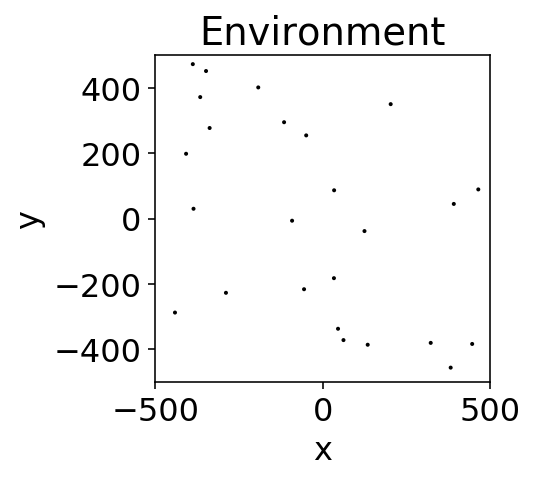

<IPython.core.display.Javascript object>

In [62]:
plot_targets2d(env, boundary=target_boundary, title="Environment")

1.01 {'average_reward': 3e-05, 'search_efficient': 4.282980109187758e-06, 'turn_ratio': 18.987826398426186}
1.5 {'average_reward': 7.4e-05, 'search_efficient': 2.5443047244207177e-05, 'turn_ratio': 7.206091332834245}
2.0 {'average_reward': 6.8e-05, 'search_efficient': 3.4061559091975764e-05, 'turn_ratio': 3.522826765858858}
2.5 {'average_reward': 6.2e-05, 'search_efficient': 3.7138304805565915e-05, 'turn_ratio': 3.7407055406300795}
2.99 {'average_reward': 0.000108, 'search_efficient': 7.188143516269005e-05, 'turn_ratio': 3.046675558082541}


Text(0, 0.5, 'Score')

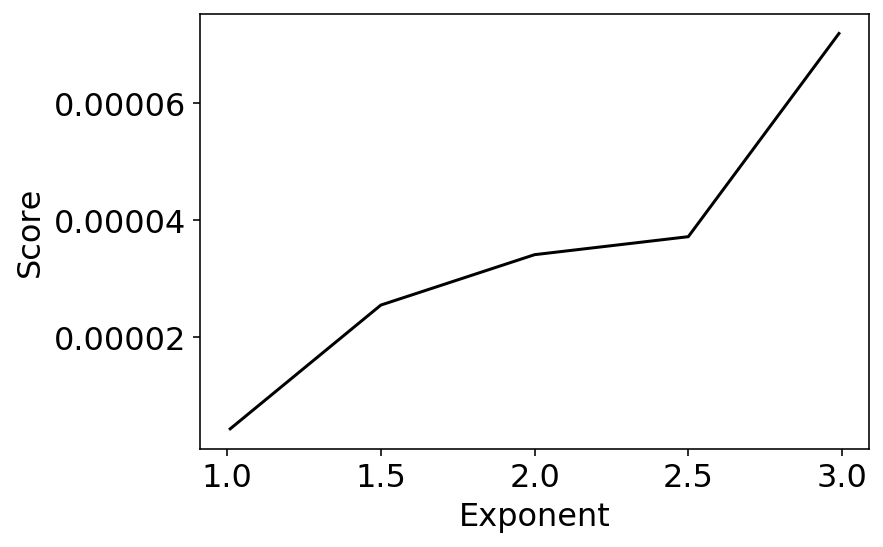

<IPython.core.display.Javascript object>

In [75]:
# Run params
norm = 1
num_experiments = 1
num_steps = 500000
seed = None

# num_exponents = 10
# exponents = np.linspace(1.01, 2.99, num_exponents)
exponents = [1.01, 1.5, 2.00, 2.5, 2.99]

# Cleanup old versions
for path in glob.glob("data/levy*_scan.pkl"):
    os.remove(path)

# !
scores = []
for x in exponents:
    # Init
    x = np.round(x, 2)
    exp_name = f"data/levy{x}_scan.pkl"
    #     levy = agent.Levy2d(exponent=x, norm=norm)
    levy = agent.TruncatedLevy2d(exponent=x, norm=norm, max_l=target_boundary[0])

    # Run repeats
    experiment(
        exp_name,
        levy,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        seed=seed,
    )

    # Measure
    exp_data = load(exp_name)
    scores.append(search_efficient(exp_data))

    # Progress
    print(x, summary2d(exp_data))

# Vis
plt.plot(exponents, scores, color="black")
plt.xlabel("Exponent")
plt.ylabel("Score")

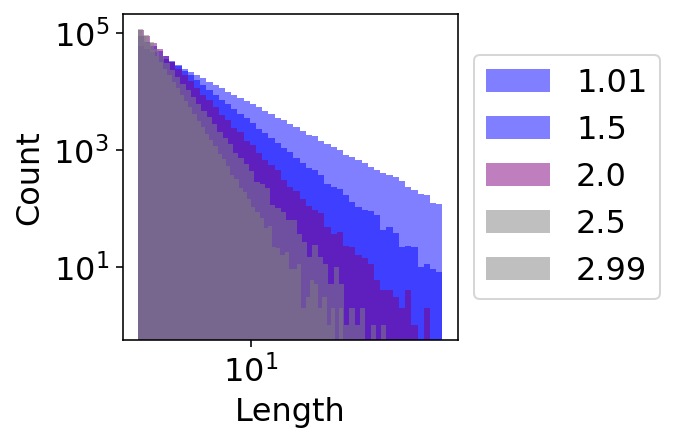

<IPython.core.display.Javascript object>

In [76]:
colors = ["blue", "blue", "purple", "grey", "grey"]
ax = None
for i, x in enumerate(exponents):
    x = np.round(x, 2)
    exp_data = load(f"data/levy{x}_scan.pkl")
    ax = plot_length_hist(
        exp_data,
        color=colors[i],
        label=str(x),
        loglog=True,
        bins=50,
        density=False,
        alpha=0.5,
        ax=ax,
    )

Look at levy u=1 up close

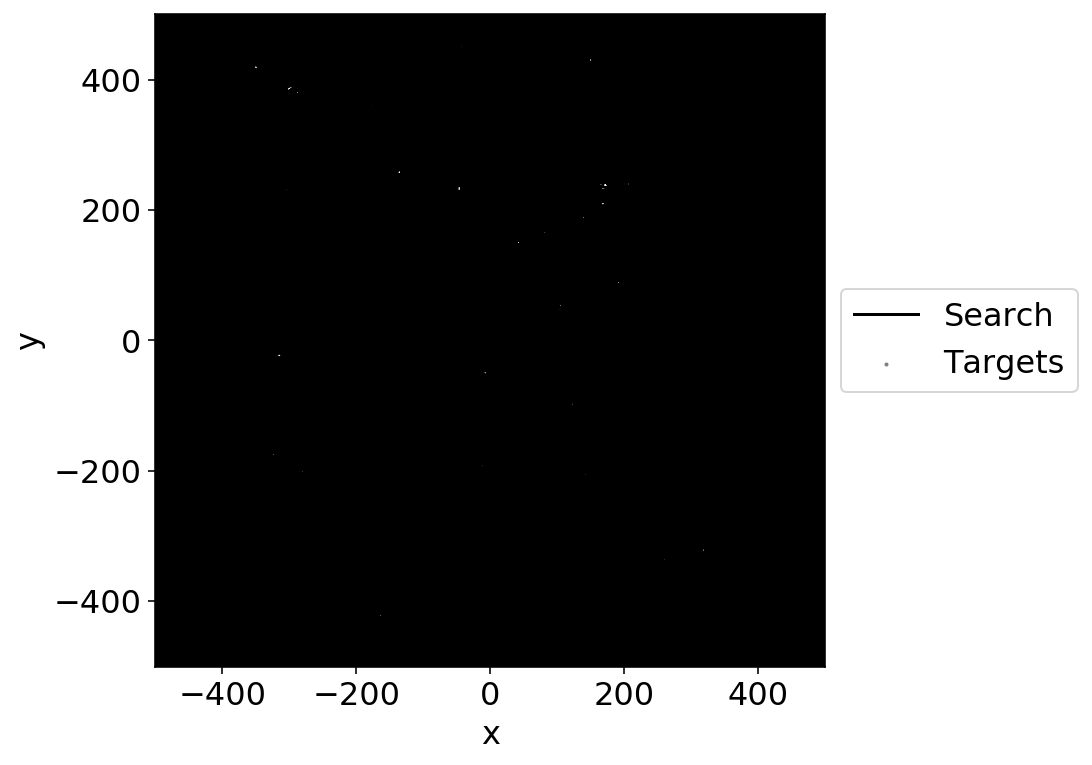

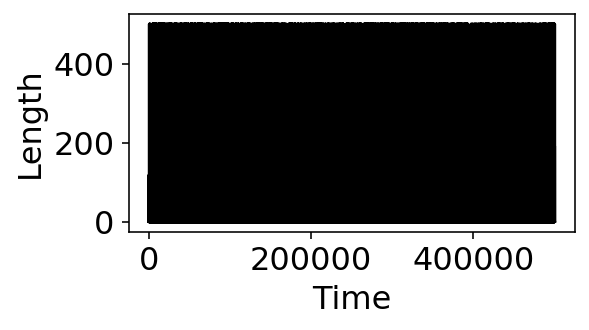

<IPython.core.display.Javascript object>

In [77]:
exp_data = load(f"data/levy1.01_scan.pkl")

# Targets (red), Search (black)
ax = plot_position2d(
    exp_data,
    boundary=target_boundary,
    label="Search",
    color="black",
    figsize=(6, 6),
)
plot_targets2d(
    env,
    boundary=target_boundary,
    color="grey",
    alpha=1,
    label="Targets",
    ax=ax,
)

# Lengths and tim
plot_length(exp_data, color="black")

Look at levy u=2 up close

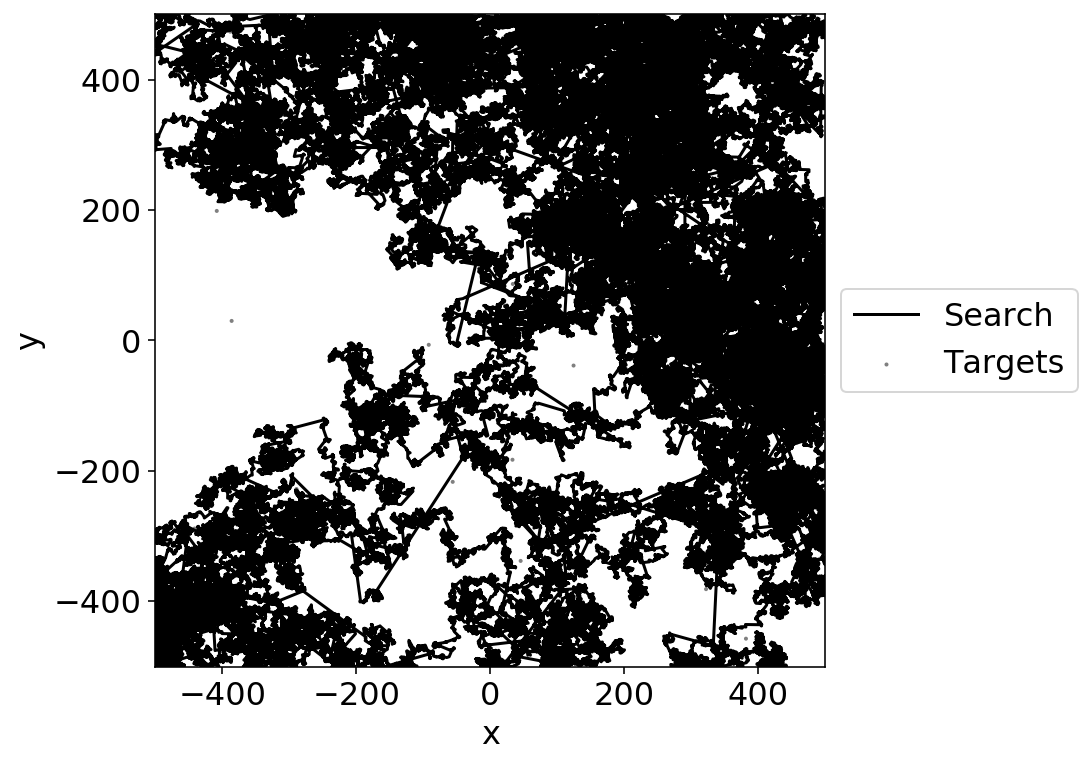

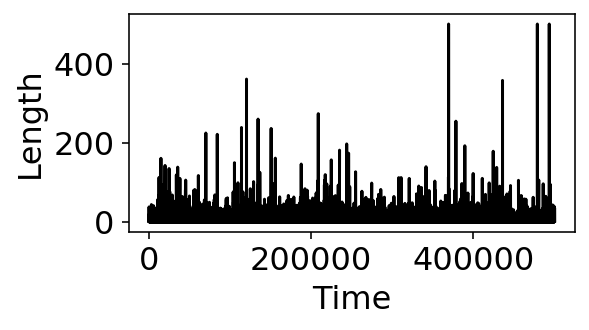

<IPython.core.display.Javascript object>

In [78]:
exp_data = load(f"data/levy2.0_scan.pkl")

# Targets (red), Search (black)
ax = plot_position2d(
    exp_data,
    boundary=target_boundary,
    label="Search",
    color="black",
    figsize=(6, 6),
)
plot_targets2d(
    env,
    boundary=target_boundary,
    color="grey",
    alpha=1,
    label="Targets",
    ax=ax,
)

# Lengths and tim
plot_length(exp_data, color="black")

Look at levy u=3 up close

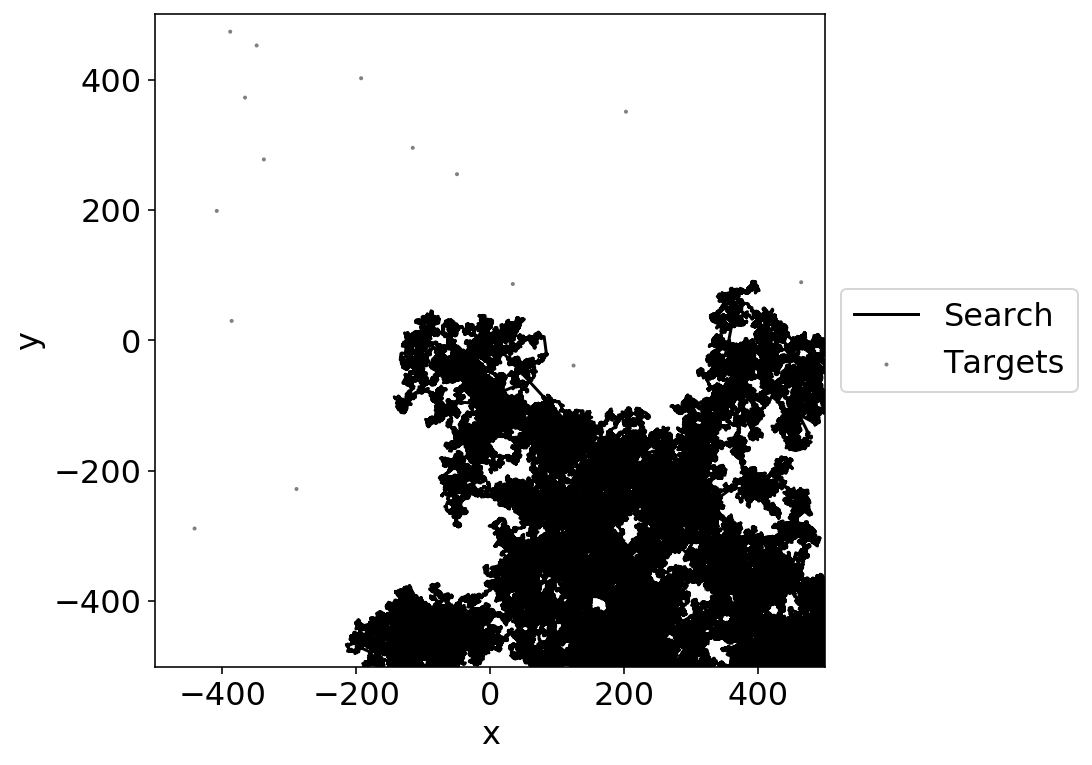

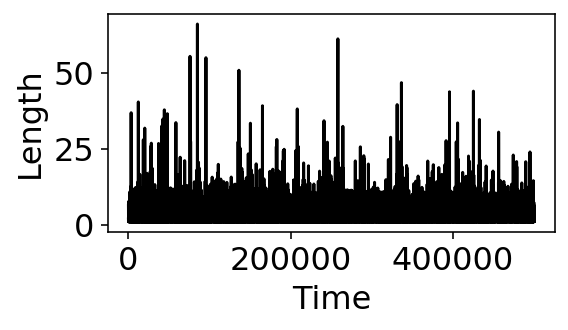

<IPython.core.display.Javascript object>

In [79]:
exp_data = load(f"data/levy2.99_scan.pkl")

# Targets (red), Search (black)
ax = plot_position2d(
    exp_data,
    boundary=target_boundary,
    label="Search",
    color="black",
    figsize=(6, 6),
)
plot_targets2d(
    env,
    boundary=target_boundary,
    color="grey",
    alpha=1,
    label="Targets",
    ax=ax,
)

# Lengths and tim
plot_length(exp_data, color="black")